# Pluralsight Take Home Assessment
## Alyssa Blair
## 09/06/24


In [52]:
!pip3 install seaborn
!pip3 install scikit-learn
!pip3 install imbalanced-learn


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/5a/fa/267de06c95210580f4b82b45cec1ce1e9ce1f21a01a684367db89e7da70d/imbalanced_learn-0.12.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip3 install --upgrade pip


In [53]:
# Basic Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew

# Feature Engineering
from sklearn.preprocessing import StandardScaler

# Modeling
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Load & Clean Data

age                   0
weight                0
bmi                   0
blood_pressure        0
insulin_test          0
liver_stress_test     0
cardio_stress_test    0
years_smoking         0
zeta_disease          0
dtype: int64


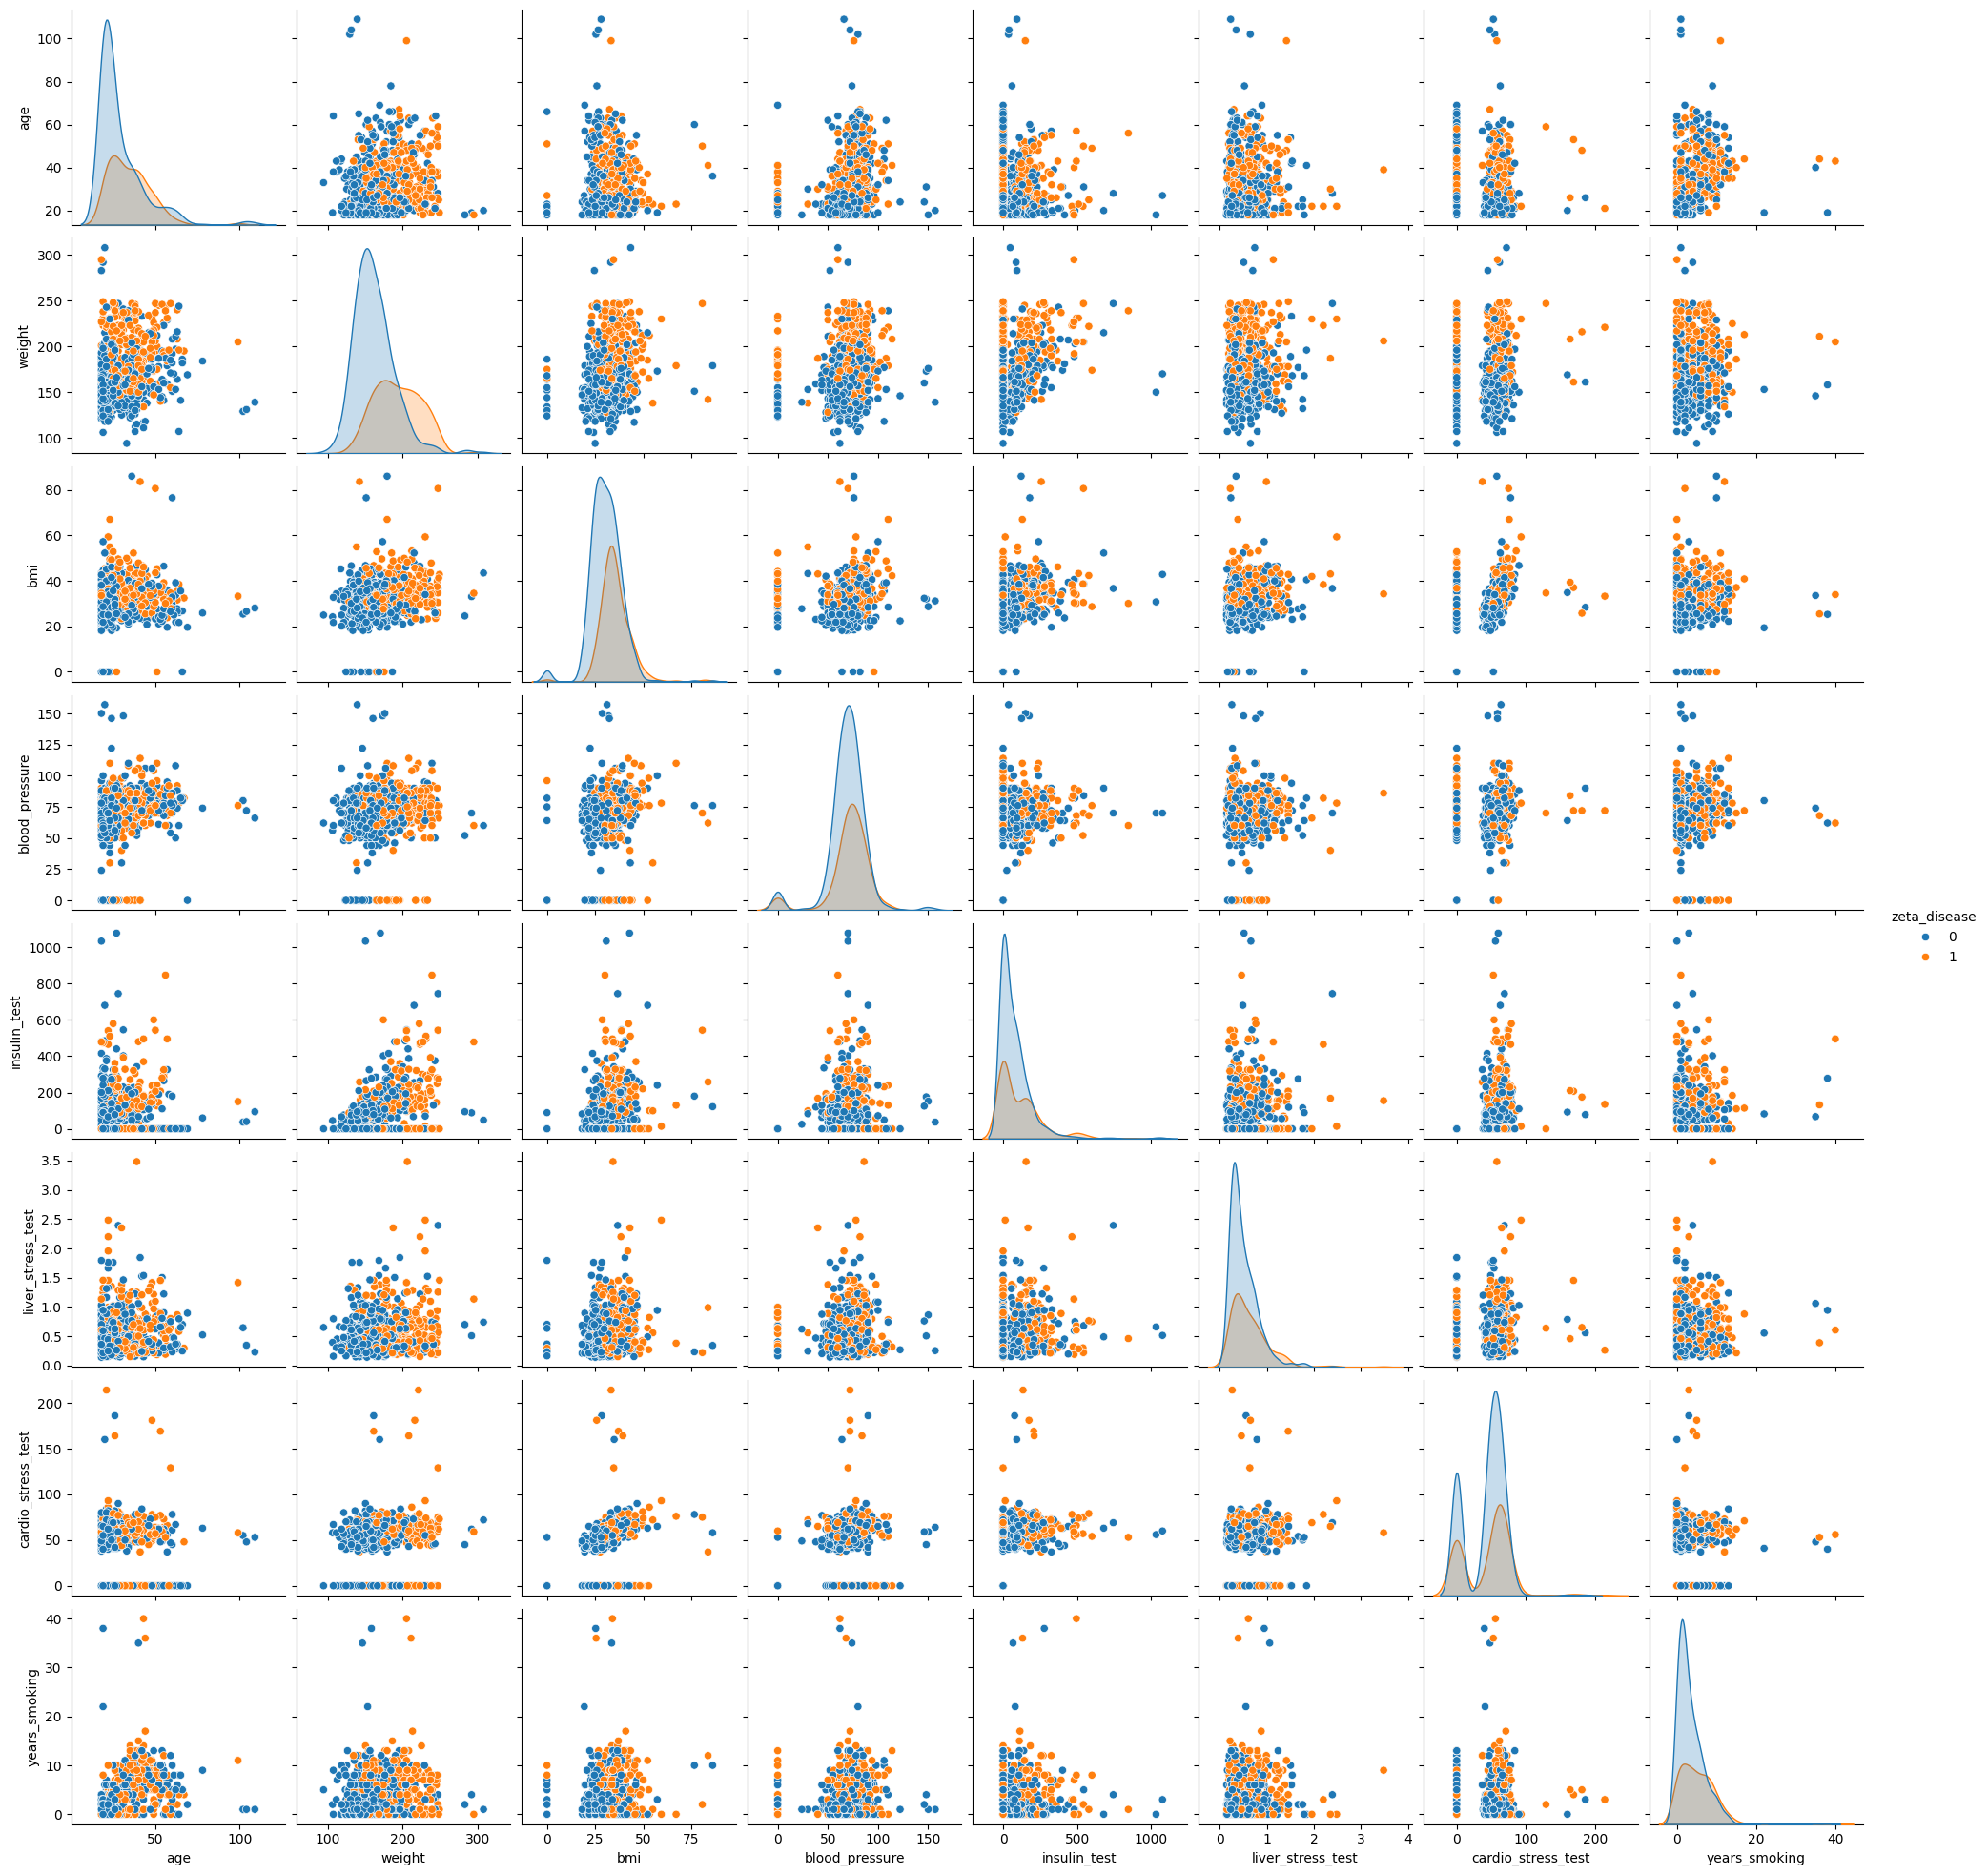

In [5]:
# Load the data
train_data = pd.read_csv('recruiting_zeta-disease_training-data_take-home-challenge.xlsx - 2021_zeta-disease_training-data.csv')
test_data = pd.read_csv('recruiting_zeta-disease_prediction-data_take-home-challenge (1).xlsx - 2021-01-21_zeta-disease_predict.csv')

# Check for missing values (Looks good)
print(train_data.isnull().sum())

# Visualize the distributions (Check distribution stats for outliers)
sns.pairplot(train_data, hue='zeta_disease')
plt.show()

# Note: From pairplot, looks like insulin_test and liver_stress_test may have outliers while there might not be clear feature separation between has/does not have zeta for age, weight, and years_smoking. 

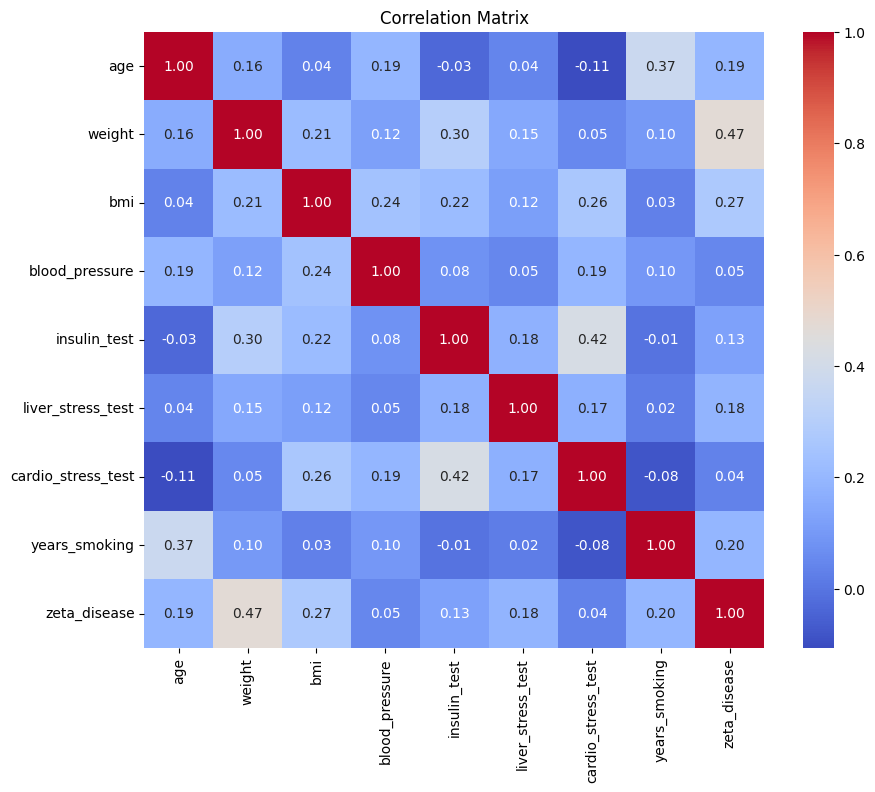

In [7]:
# Calculate correlations
correlations = train_data.corr()

# Visualize correlations using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Note: For correlations, looks like only weight is moderately, positively correlated with having zeta_disease, doesn't look like there will be multicollinearity issues btwn predictors (moderate positive correlations btwn smoking/age & insulin/stress test)

In [22]:
# Descriptive Stats
descriptive_stats = train_data.describe()

# Check for skewness
skewness = train_data.skew()

# Print stats for review 
print("Descriptive Statistics:\n", descriptive_stats)
print("\nSkewness:\n", skewness)

# Note: Some skew, best to address anything with higher skew, such as insulin, liver_stress_test, and years_smoking; I fear for anyone with insulin of 1077, possible error but will transform instead of remove due to low sample size

Descriptive Statistics:
                 age        weight           bmi  blood_pressure  insulin_test  \
count  8.000000e+02  8.000000e+02  8.000000e+02    8.000000e+02    800.000000   
mean   4.440892e-17  3.441691e-17 -4.440892e-18    1.132427e-16     85.887500   
std    1.000626e+00  1.000626e+00  1.000626e+00    1.000626e+00    126.333656   
min   -9.398944e-01 -2.456185e+00 -3.769001e+00   -3.502354e+00      0.000000   
25%   -7.227451e-01 -7.332610e-01 -5.737048e-01   -3.808712e-01      0.000000   
50%   -3.608297e-01 -1.693948e-01 -1.774677e-02    1.225937e-01     45.000000   
75%    5.077674e-01  6.137527e-01  5.060243e-01    5.253656e-01    130.000000   
max    5.646967e+00  4.247557e+00  6.308471e+00    4.402045e+00   1077.000000   

       liver_stress_test  cardio_stress_test  years_smoking  zeta_disease  \
count         800.000000        8.000000e+02     800.000000    800.000000   
mean            0.544496       -1.043610e-16       4.051250      0.348750   
std           

In [15]:
# Log transformation for insulin_test and liver_stress_test (log works well for correcting skew on continuous data)
train_data['insulin_test_log'] = np.log1p(train_data['insulin_test'])
train_data['liver_stress_test_log'] = np.log1p(train_data['liver_stress_test'])

# Square root transformation for years_smoking (square root works well for correcting skew on count data)
train_data['years_smoking_sqrt'] = np.sqrt(train_data['years_smoking'])

# Apply same transformations on test data (for later prediction)
test_data['insulin_test_log'] = np.log1p(test_data['insulin_test'])
test_data['liver_stress_test_log'] = np.log1p(test_data['liver_stress_test'])
test_data['years_smoking_sqrt'] = np.sqrt(test_data['years_smoking'])

zeta_disease
0    521
1    279
Name: count, dtype: int64


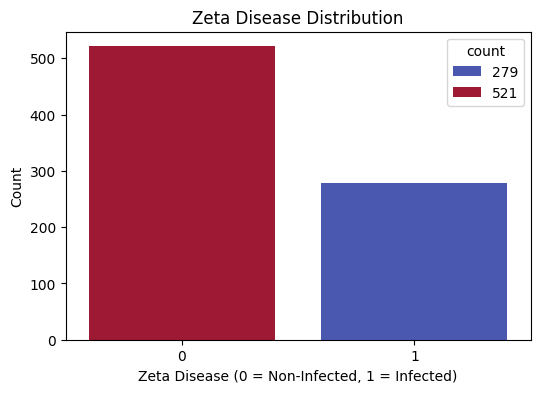

In [48]:
# Check the distribution of the target variable (zeta_disease)
zeta_counts = train_data['zeta_disease'].value_counts()
print(zeta_counts)

# Create a bar chart for infected vs non-infected
plt.figure(figsize=(6,4))
sns.barplot(x=zeta_counts.index, y=zeta_counts.values, palette='coolwarm', hue= zeta_counts)
plt.title('Zeta Disease Distribution')
plt.xlabel('Zeta Disease (0 = Non-Infected, 1 = Infected)')
plt.ylabel('Count')
plt.show()

# Note: Pretty imbalanced classes here, with nearly twice as many non-infected as infected, will want to use class balancing (SMOTE, etc.)

## Feature Engineering

In [54]:
# Standardize features
features = ['age', 'weight', 'bmi', 'blood_pressure', 
            'insulin_test_log', 'liver_stress_test_log', 
            'cardio_stress_test', 'years_smoking_sqrt']
scaler = StandardScaler()
train_data[features] = scaler.fit_transform(train_data[features])
test_data[features] = scaler.transform(test_data[features])

## Model Training

In [55]:
# Split for test-train
X = train_data.drop(columns=['zeta_disease'])
y = train_data['zeta_disease']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to help with the target class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Confirm new class distribution
print(f"Resampled class distribution:\n{pd.Series(y_resampled).value_counts()}")

# Quick function for plotting confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

Resampled class distribution:
zeta_disease
0    412
1    412
Name: count, dtype: int64


### Logistic Regression

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       109
           1       0.57      0.53      0.55        51

    accuracy                           0.72       160
   macro avg       0.68      0.67      0.68       160
weighted avg       0.72      0.72      0.72       160



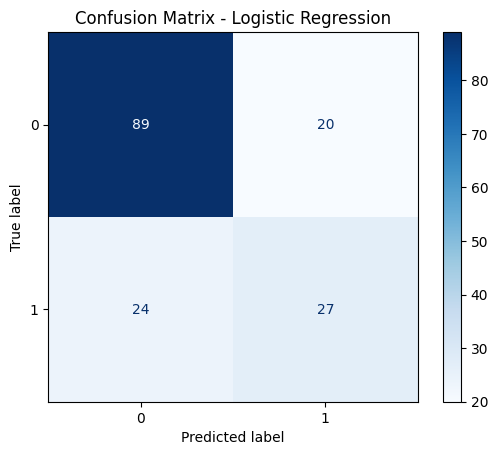

In [35]:
# Note:  Let's start with a quick logistic regression (simple, lightweight, might be perfectly fine depending on intended use case and sets a decent benchmark)

# Train LR model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predict on validation data
y_pred_log_reg = log_reg.predict(X_val)

# Classification report
print(classification_report(y_val, y_pred_log_reg))

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_log_reg)

# Plot the confusion matrix
plot_confusion_matrix(y_val, y_pred_log_reg, "Confusion Matrix - Logistic Regression")

# Note: Okay, pretty poor performance on the test class, likely due the the imbalanced classes, let's try LR with SMOTE.

              precision    recall  f1-score   support

           0       0.87      0.74      0.80       109
           1       0.58      0.76      0.66        51

    accuracy                           0.75       160
   macro avg       0.73      0.75      0.73       160
weighted avg       0.78      0.75      0.76       160



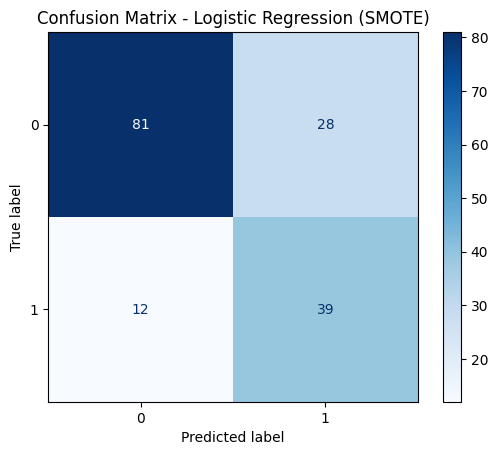

In [56]:
# Train the LR on the SMOTE resampled data
log_reg_SMOTE = LogisticRegression(max_iter=1000, random_state=42)
log_reg_SMOTE.fit(X_resampled, y_resampled)

# Predict on validation data
y_pred_log_reg_SMOTE = log_reg_SMOTE.predict(X_val)

# Classification report
print(classification_report(y_val, y_pred_log_reg_SMOTE))

# Confusion matrix
plot_confusion_matrix(y_val, y_pred_log_reg_SMOTE, "Confusion Matrix - Logistic Regression (SMOTE)")

# Note: Yeah, definitely improved recall on the target class, slighty better overall F1. 

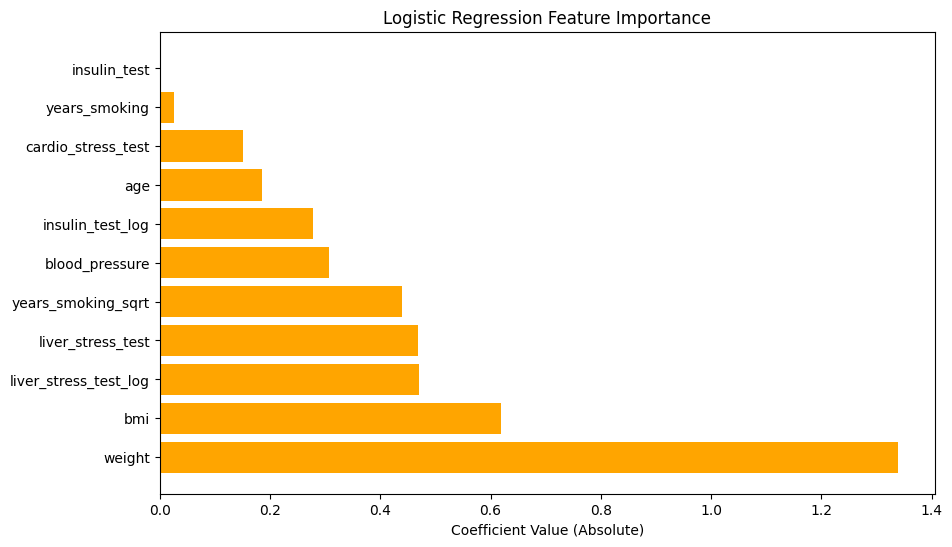

In [72]:
# LR feature importance (using absolute coefficients, larger coef = stronger relationship)
coefficients = np.abs(log_reg_SMOTE.coef_[0])
sorted_idx = np.argsort(coefficients)[::-1]

plt.figure(figsize=(10,6))
plt.barh(X_train.columns[sorted_idx], coefficients[sorted_idx], color='orange')
plt.xlabel('Coefficient Value (Absolute)')
plt.title('Logistic Regression Feature Importance')
plt.show()

# Note: This aligns with what we saw in the original correlations with weight and the related bmi variables having a stronger relationship to zeta_disease presence. 

### Random Forest

CV Accuracy (without SMOTE): 0.765625
Random Forest (without SMOTE) Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       109
           1       0.67      0.63      0.65        51

    accuracy                           0.78       160
   macro avg       0.75      0.74      0.74       160
weighted avg       0.78      0.78      0.78       160



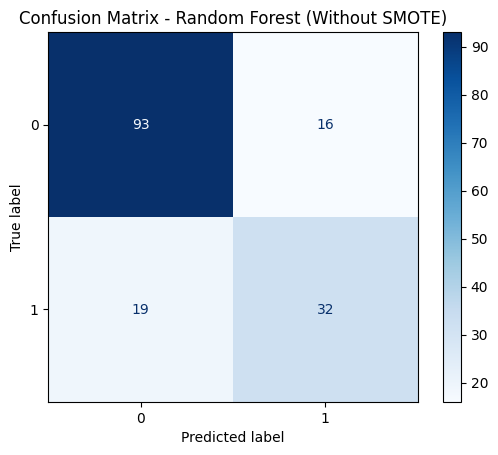

ROC-AUC Score (without SMOTE): 0.8202914193200215


In [64]:
# Train a Random Forest (no SMOTE)
rf_model_no_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_no_smote.fit(X_train, y_train)

# Cross-validation
cv_scores_no_smote = cross_val_score(rf_model_no_smote, X_train, y_train, cv=5)
print(f"CV Accuracy (without SMOTE): {cv_scores_no_smote.mean()}")

# Predict on validation data
y_pred_no_smote = rf_model_no_smote.predict(X_val)

# Classification report
print("Random Forest (without SMOTE) Classification Report:")
print(classification_report(y_val, y_pred_no_smote))

# Confusion matrix
plot_confusion_matrix(y_val, y_pred_no_smote, "Confusion Matrix - Random Forest (Without SMOTE)")

# ROC-AUC Score
print(f"ROC-AUC Score (without SMOTE): {roc_auc_score(y_val, rf_model_no_smote.predict_proba(X_val)[:,1])}")

# Note: Very similar to the LR w/ SMOTE results for the target class, slightly higher overall F1. Decent CV accuracy and ROC-AUC.

CV Accuracy (with SMOTE): 0.8241241685144125
Random Forest (with SMOTE) Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       109
           1       0.57      0.67      0.61        51

    accuracy                           0.73       160
   macro avg       0.70      0.71      0.70       160
weighted avg       0.75      0.73      0.74       160



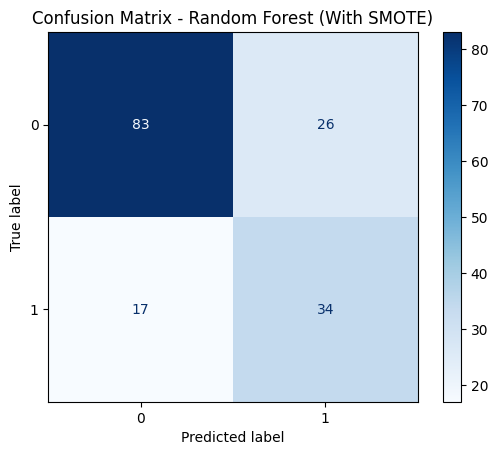

ROC-AUC Score (with SMOTE): 0.8201115308508724


In [65]:
# Train a Random Forest with SMOTE
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_smote.fit(X_resampled, y_resampled)

# Cross-validation
cv_scores_smote = cross_val_score(rf_model_smote, X_resampled, y_resampled, cv=5)
print(f"CV Accuracy (with SMOTE): {cv_scores_smote.mean()}")

# Predict on validation data
y_pred_smote = rf_model_smote.predict(X_val)

# Classification report
print("Random Forest (with SMOTE) Classification Report:")
print(classification_report(y_val, y_pred_smote))

# Confusion matrix
plot_confusion_matrix(y_val, y_pred_smote, "Confusion Matrix - Random Forest (With SMOTE)")

# ROC-AUC Score
print(f"ROC-AUC Score (with SMOTE): {roc_auc_score(y_val, rf_model_smote.predict_proba(X_val)[:,1])}")

# Note: SMOTE actually doesn't improve overall performance above the no-SMOTE RF model, suggesting it may have slightly distorted the feature space. However, target class (infected) recall is slightly better even if precision is lower. 

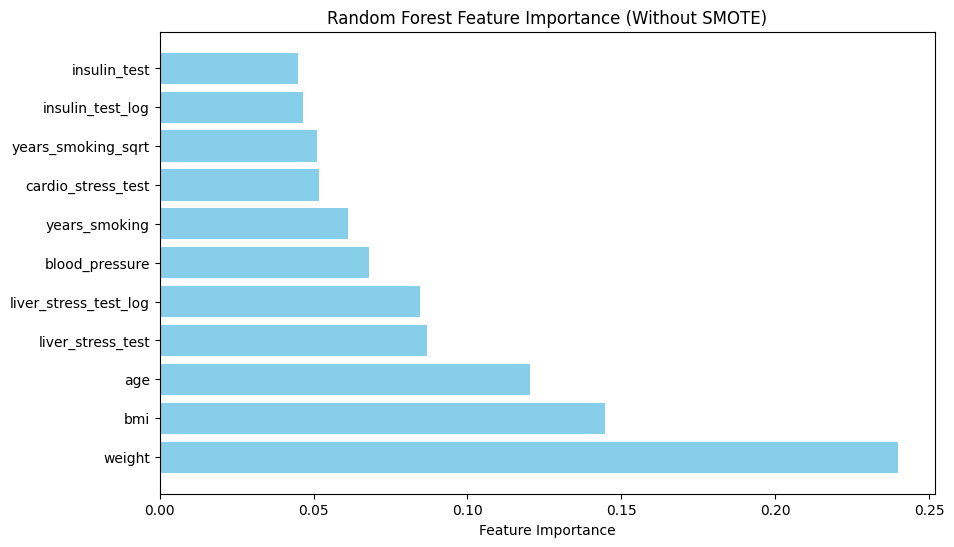

In [73]:
# Random Forest feature importance
importances = rf_model_no_smote.feature_importances_
feature_names = X_train.columns

# Sort the feature importance values
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (Without SMOTE)')
plt.show()

# Note: Yep, similar to what we saw in the correlations and the LR coefficients, with weight being the most impactful feature. 

## Test Data Prediction

### Note: I’m going to stop here to avoid over-engineering, but additional steps could include trying GBM models like XGBoost that handle class imbalances and non-linear relationships well since they allow for iteration and more precise hyperparameter tuning. For addressing class imbalance, we could also explore generating synthetic data, bootstrapping, or adversarial training. Further feature engineering might include interaction terms, binarizing variables like BMI (e.g., under/average/overweight), or capturing non-linear relationships. These steps could enhance performance but require further time and consideration.
 
### Model Selection Rationale: While it might feel most natural to choose the model with the highest overall accuracy (Random Forest without SMOTE, overall F1 of 0.78, infected recall of 0.63), recall for the infected class is typically considered much more important in real world disease prediction because it prioritizes capturing as many of the true cases as possible. In the case of Zeta Disease, a false negative (missing an infected person) could have much worse consequences than a false positive (incorrectly predicting a healthy person will get sick). So, I've chosen to run my test predictions with the model that has the highest overall recall for predicting infected cases (the Logistic Regression with SMOTE, overall F1 of 0.75, infected recall of 0.76) in order to detect as many high-risk individuals as possible. I expect this may lower overall test accuracy but it will reduce the false negative rate.   

In [78]:
# Drop the target placeholder column 
test_data = test_data.drop(columns=['zeta_disease'], errors='ignore')

# Generate predictions for the test data
test_predictions = log_reg_SMOTE.predict(test_data)

# Save the predictions to the test data
output = test_data.copy()  # Create a copy of the test data for output
output['zeta_disease'] = test_predictions

# Save results to CSV
output.to_csv('zeta_disease_predictions.csv', index=False)

In [79]:
output

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,insulin_test_log,liver_stress_test_log,years_smoking_sqrt,zeta_disease
0,-0.505596,-0.670609,0.854230,-0.028446,72,1.3968,0.423769,4,0.688415,2.353027,0.265420,0
1,-0.288447,0.206516,0.386054,0.978484,156,1.6608,-0.003990,6,0.999459,2.887260,0.698481,1
2,0.218235,-0.795913,-0.620522,0.323980,74,1.6958,0.325056,2,0.699394,2.954073,-0.298955,0
3,0.290618,1.052315,0.023219,0.172940,127,1.4608,0.588292,6,0.916512,2.487755,0.698481,1
4,2.100195,0.645079,-0.281095,-0.380871,192,1.7798,0.719910,9,1.083312,3.110950,1.228869,1
5,1.014449,-1.641712,0.503098,1.935067,50,1.2978,0.357960,12,0.542747,2.137363,1.676007,0
6,-0.795128,-1.046520,0.702073,-0.431218,77,1.5818,0.818624,3,0.715324,2.733164,0.007265,0
7,-0.577979,-1.109172,-0.117234,0.021901,73,1.4168,0.522483,7,0.693941,2.395512,0.887569,0
8,0.363001,0.707730,-0.199165,-0.531911,141,1.4498,0.522483,6,0.958672,2.464850,0.698481,1
9,-0.867511,0.645079,-0.749271,0.726752,66,1.7938,0.226342,3,0.653579,3.136634,0.007265,1
